In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
df = pd.read_csv('../data/Exoplanet_Dataset.csv')

print("="*80)
print("STAGE 2: TEMPERATURE PREDICTION - DATA PREPARATION")
print("="*80)

stage2_features = ['star_teff', 'semi_major_axis']
stage2_target = 'temp_calculated'

stage2_cols = stage2_features + [stage2_target]
df_stage2 = df[stage2_cols].dropna()

print(f"\nOriginal dataset: {len(df)} rows")
print(f"Stage 2 available data: {len(df_stage2)} rows")
print(f"\nFeatures: {stage2_features}")
print(f"Target: {stage2_target}")

print("\nFirst 5 rows of Stage 2 data:")
df_stage2.head()

STAGE 2: TEMPERATURE PREDICTION - DATA PREPARATION

Original dataset: 5986 rows
Stage 2 available data: 1881 rows

Features: ['star_teff', 'semi_major_axis']
Target: temp_calculated

First 5 rows of Stage 2 data:


,star_teff,semi_major_axis,temp_calculated
56,3700.0,0.07000,569.5
57,3700.0,0.11900,436.0
59,3195.0,0.02294,438.0
60,3195.0,0.02740,400.0
61,3195.0,0.01880,483.0


In [3]:
print("="*80)
print("STAGE 2 DATA STATISTICS")
print("="*80)

print("\nFeature Statistics:")
print(df_stage2[stage2_features].describe())

print("\nTarget Statistics:")
print(df_stage2[stage2_target].describe())

# Check skewness
from scipy import stats
temp_skew = stats.skew(df_stage2[stage2_target])
print(f"\nTemperature Skewness: {temp_skew:.3f}")
print("Note: Skewness ~1.0 (slightly skewed, acceptable)")

print(f"\nDataset shape: {df_stage2.shape}")
print(f"Features: {df_stage2.shape[1] - 1}")
print(f"Samples: {df_stage2.shape[0]}")

STAGE 2 DATA STATISTICS

Feature Statistics:
          star_teff  semi_major_axis
count   1881.000000      1881.000000
mean    5226.094694         0.228517
std      955.528851         2.400549
min     2560.000000         0.005400
25%     4717.000000         0.043600
50%     5449.000000         0.066870
75%     5842.000000         0.122800
max    11000.000000        87.000000

Target Statistics:
count    1881.000000
mean      939.688974
std       501.471884
min        56.000000
25%       566.000000
50%       837.000000
75%      1237.000000
max      3921.000000
Name: temp_calculated, dtype: float64

Temperature Skewness: 1.014
Note: Skewness ~1.0 (slightly skewed, acceptable)

Dataset shape: (1881, 3)
Features: 2
Samples: 1881


In [4]:
X = df_stage2[stage2_features]
y = df_stage2[stage2_target]

# Train/Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print("="*80)
print("TRAIN/TEST SPLIT (80/20)")
print("="*80)
print(f"\nTraining set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print("\nTraining set shape:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")

print("\nTest set shape:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

TRAIN/TEST SPLIT (80/20)

Training set: 1504 samples (80.0%)
Test set: 377 samples (20.0%)

Training set shape:
  X_train: (1504, 2)
  y_train: (1504,)

Test set shape:
  X_test: (377, 2)
  y_test: (377,)


In [5]:
print("="*80)
print("MODEL 1: LINEAR REGRESSION (BASELINE)")
print("="*80)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

lr_train_mae = mean_absolute_error(y_train, y_pred_lr_train)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
lr_train_r2 = r2_score(y_train, y_pred_lr_train)

lr_test_mae = mean_absolute_error(y_test, y_pred_lr_test)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
lr_test_r2 = r2_score(y_test, y_pred_lr_test)

print("\nTraining Set Performance:")
print(f"  MAE:  {lr_train_mae:.2f} K")
print(f"  RMSE: {lr_train_rmse:.2f} K")
print(f"  R²:   {lr_train_r2:.4f}")

print("\nTest Set Performance:")
print(f"  MAE:  {lr_test_mae:.2f} K")
print(f"  RMSE: {lr_test_rmse:.2f} K")
print(f"  R²:   {lr_test_r2:.4f}")

print("\nFeature Coefficients:")
for feature, coef in zip(stage2_features, lr_model.coef_):
    print(f"  {feature}: {coef:.6f}")
print(f"  Intercept: {lr_model.intercept_:.2f}")

MODEL 1: LINEAR REGRESSION (BASELINE)

Training Set Performance:
  MAE:  330.07 K
  RMSE: 424.43 K
  R²:   0.2628

Test Set Performance:
  MAE:  322.15 K
  RMSE: 425.07 K
  R²:   0.3514

Feature Coefficients:
  star_teff: 0.273339
  semi_major_axis: -21.889056
  Intercept: -489.27


In [6]:
print("="*80)
print("MODEL 2: RANDOM FOREST (TUNED PARAMETERS)")
print("="*80)

# Train Random Forest with tuned parameters
# (Learning from Stage 1, we start with conservative params)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

rf_train_mae = mean_absolute_error(y_train, y_pred_rf_train)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
rf_train_r2 = r2_score(y_train, y_pred_rf_train)

rf_test_mae = mean_absolute_error(y_test, y_pred_rf_test)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
rf_test_r2 = r2_score(y_test, y_pred_rf_test)

print("\nTraining Set Performance:")
print(f"  MAE:  {rf_train_mae:.2f} K")
print(f"  RMSE: {rf_train_rmse:.2f} K")
print(f"  R²:   {rf_train_r2:.4f}")

print("\nTest Set Performance:")
print(f"  MAE:  {rf_test_mae:.2f} K")
print(f"  RMSE: {rf_test_rmse:.2f} K")
print(f"  R²:   {rf_test_r2:.4f}")

print("\nFeature Importance:")
for feature, importance in zip(stage2_features, rf_model.feature_importances_):
    print(f"  {feature}: {importance:.4f}")

MODEL 2: RANDOM FOREST (TUNED PARAMETERS)

Training Set Performance:
  MAE:  80.73 K
  RMSE: 135.96 K
  R²:   0.9243

Test Set Performance:
  MAE:  117.80 K
  RMSE: 206.79 K
  R²:   0.8465

Feature Importance:
  star_teff: 0.4830
  semi_major_axis: 0.5170


In [7]:
print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'Train_MAE': [lr_train_mae, rf_train_mae],
    'Test_MAE': [lr_test_mae, rf_test_mae],
    'Train_RMSE': [lr_train_rmse, rf_train_rmse],
    'Test_RMSE': [lr_test_rmse, rf_test_rmse],
    'Train_R2': [lr_train_r2, rf_train_r2],
    'Test_R2': [lr_test_r2, rf_test_r2]
})

print("\n", comparison.to_string(index=False))

best_model_name = 'Random Forest' if rf_test_r2 > lr_test_r2 else 'Linear Regression'
best_r2 = max(rf_test_r2, lr_test_r2)
best_mae = min(rf_test_mae, lr_test_mae)

print(f"\nBest model (by Test R²): {best_model_name}")
print(f"   Test R²: {best_r2:.4f}")
print(f"   Test MAE: {best_mae:.2f} K")

print("\nOverfitting Check:")
lr_overfit = lr_train_r2 - lr_test_r2
rf_overfit = rf_train_r2 - rf_test_r2
print(f"  Linear Regression: {lr_overfit:.4f} (Train R² - Test R²)")
print(f"  Random Forest: {rf_overfit:.4f} (Train R² - Test R²)")

if rf_overfit > 0.1:
    print("  Note: Random Forest shows signs of overfitting")
else:
    print("  No significant overfitting detected")

MODEL COMPARISON SUMMARY

             Model  Train_MAE   Test_MAE  Train_RMSE  Test_RMSE  Train_R2  Test_R2
Linear Regression 330.073585 322.151046  424.433046 425.067178  0.262763 0.351376
    Random Forest  80.732417 117.804476  135.963017 206.787357  0.924346 0.846494

Best model (by Test R²): Random Forest
   Test R²: 0.8465
   Test MAE: 117.80 K

Overfitting Check:
  Linear Regression: -0.0886 (Train R² - Test R²)
  Random Forest: 0.0779 (Train R² - Test R²)
  No significant overfitting detected


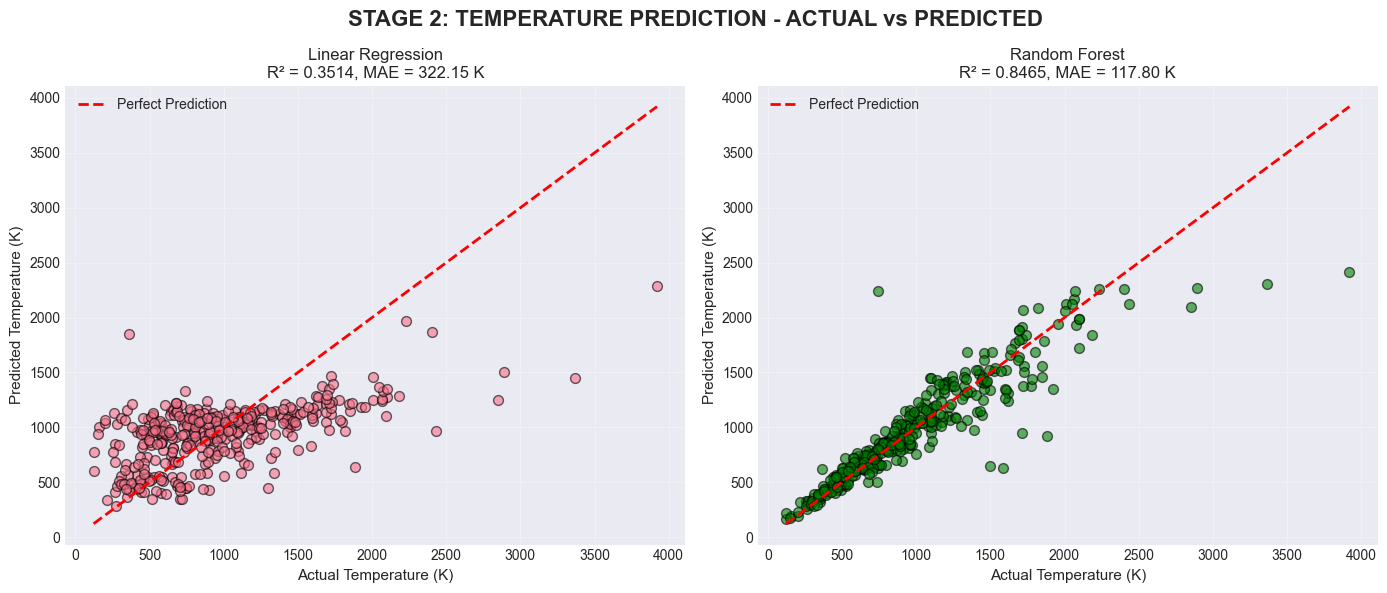

Figure saved: ../outputs/figures/stage2_predictions.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('STAGE 2: TEMPERATURE PREDICTION - ACTUAL vs PREDICTED', 
             fontsize=16, fontweight='bold')

# Linear Regression
ax1 = axes[0]
ax1.scatter(y_test, y_pred_lr_test, alpha=0.6, edgecolors='k', s=50)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Temperature (K)', fontsize=11)
ax1.set_ylabel('Predicted Temperature (K)', fontsize=11)
ax1.set_title(f'Linear Regression\nR² = {lr_test_r2:.4f}, MAE = {lr_test_mae:.2f} K', 
              fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Random Forest
ax2 = axes[1]
ax2.scatter(y_test, y_pred_rf_test, alpha=0.6, edgecolors='k', s=50, color='green')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Temperature (K)', fontsize=11)
ax2.set_ylabel('Predicted Temperature (K)', fontsize=11)
ax2.set_title(f'Random Forest\nR² = {rf_test_r2:.4f}, MAE = {rf_test_mae:.2f} K', 
              fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/stage2_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: ../outputs/figures/stage2_predictions.png")

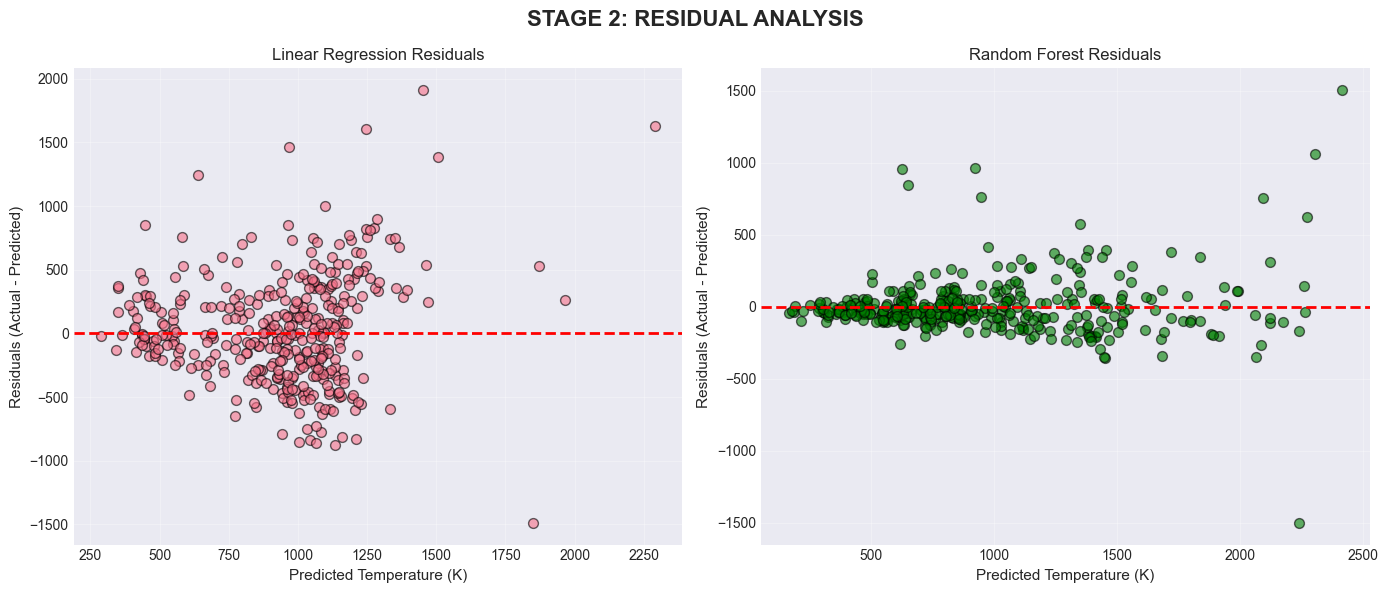

Figure saved: ../outputs/figures/stage2_residuals.png


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('STAGE 2: RESIDUAL ANALYSIS', fontsize=16, fontweight='bold')

lr_residuals = y_test - y_pred_lr_test
rf_residuals = y_test - y_pred_rf_test

# Linear Regression residuals
ax1 = axes[0]
ax1.scatter(y_pred_lr_test, lr_residuals, alpha=0.6, edgecolors='k', s=50)
ax1.axhline(y=0, color='r', linestyle='--', lw=2)
ax1.set_xlabel('Predicted Temperature (K)', fontsize=11)
ax1.set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
ax1.set_title('Linear Regression Residuals', fontsize=12)
ax1.grid(True, alpha=0.3)

# Random Forest residuals
ax2 = axes[1]
ax2.scatter(y_pred_rf_test, rf_residuals, alpha=0.6, edgecolors='k', s=50, color='green')
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Temperature (K)', fontsize=11)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
ax2.set_title('Random Forest Residuals', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/stage2_residuals.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: ../outputs/figures/stage2_residuals.png")

In [10]:
joblib.dump(lr_model, '../models/stage2_linear_regression.pkl')
joblib.dump(rf_model, '../models/stage2_random_forest.pkl')

if best_model_name == 'Random Forest':
    joblib.dump(rf_model, '../models/stage2_FINAL_model.pkl')
else:
    joblib.dump(lr_model, '../models/stage2_FINAL_model.pkl')

print("="*80)
print("MODELS SAVED")
print("="*80)
print("\nLinear Regression saved: ../models/stage2_linear_regression.pkl")
print("Random Forest saved: ../models/stage2_random_forest.pkl")
print(f"Final model ({best_model_name}) saved: ../models/stage2_FINAL_model.pkl")

predictions_df = pd.DataFrame({
    'actual': y_test.values,
    'lr_predicted': y_pred_lr_test,
    'rf_predicted': y_pred_rf_test
})
predictions_df.to_csv('../outputs/stage2_predictions.csv', index=False)
print("Predictions saved: ../outputs/stage2_predictions.csv")

MODELS SAVED

Linear Regression saved: ../models/stage2_linear_regression.pkl
Random Forest saved: ../models/stage2_random_forest.pkl
Final model (Random Forest) saved: ../models/stage2_FINAL_model.pkl
Predictions saved: ../outputs/stage2_predictions.csv


In [11]:
print("="*80)
print("STAGE 2: TEMPERATURE PREDICTION - COMPLETE")
print("="*80)

print("\nRESULTS SUMMARY:")
print(f"\nDataset: {len(df_stage2)} samples")
print(f"Training: {len(X_train)} samples")
print(f"Testing: {len(X_test)} samples")

print(f"\nBEST MODEL: {best_model_name}")
print(f"  Test R²: {best_r2:.4f}")
print(f"  Test MAE: {best_mae:.2f} K")
print(f"  Test RMSE: {min(rf_test_rmse, lr_test_rmse):.2f} K")

print("\nCOMPARISON WITH STAGE 1:")
print("  Stage 1 (Mass): R² = 0.0755 (challenging - high skewness)")
print(f"  Stage 2 (Temp): R² = {best_r2:.4f}")
if best_r2 > 0.4:
    print("  Stage 2 shows significantly better performance!")
elif best_r2 > 0.2:
    print("  Note: Stage 2 is moderate - acceptable for MVP")
else:
    print("  Note: Stage 2 needs improvement in V2")

print("\nCOMPLETED:")
print("  - Data preprocessing")
print("  - Linear Regression baseline")
print("  - Random Forest (tuned)")
print("  - Model comparison")
print("  - Best model saved")

print("\nNEXT STEP:")
print("  Stage 3: ESI Calculation (Formula-based)")

print("\n" + "="*80)

STAGE 2: TEMPERATURE PREDICTION - COMPLETE

RESULTS SUMMARY:

Dataset: 1881 samples
Training: 1504 samples
Testing: 377 samples

BEST MODEL: Random Forest
  Test R²: 0.8465
  Test MAE: 117.80 K
  Test RMSE: 206.79 K

COMPARISON WITH STAGE 1:
  Stage 1 (Mass): R² = 0.0755 (challenging - high skewness)
  Stage 2 (Temp): R² = 0.8465
  Stage 2 shows significantly better performance!

COMPLETED:
  - Data preprocessing
  - Linear Regression baseline
  - Random Forest (tuned)
  - Model comparison
  - Best model saved

NEXT STEP:
  Stage 3: ESI Calculation (Formula-based)

